In [1]:
import numpy as np
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers import Dense, Activation
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

In [2]:

# Load text
path = '1661-0.txt'
text = open(path, encoding='utf-8').read().lower()
print('corpus length:', len(text))

# Tokenize text — extract only words (no punctuation)
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

print(words[:50])  # show first 50 words


corpus length: 581888
['project', 'gutenberg', 's', 'the', 'adventures', 'of', 'sherlock', 'holmes', 'by', 'arthur', 'conan', 'doyle', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restrictions', 'whatsoever', 'you', 'may', 'copy', 'it', 'give', 'it', 'away', 'or', 're', 'use', 'it', 'under', 'the', 'terms', 'of', 'the', 'project', 'gutenberg', 'license', 'included']


In [3]:
print(words)

['project', 'gutenberg', 's', 'the', 'adventures', 'of', 'sherlock', 'holmes', 'by', 'arthur', 'conan', 'doyle', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restrictions', 'whatsoever', 'you', 'may', 'copy', 'it', 'give', 'it', 'away', 'or', 're', 'use', 'it', 'under', 'the', 'terms', 'of', 'the', 'project', 'gutenberg', 'license', 'included', 'with', 'this', 'ebook', 'or', 'online', 'at', 'www', 'gutenberg', 'net', 'title', 'the', 'adventures', 'of', 'sherlock', 'holmes', 'author', 'arthur', 'conan', 'doyle', 'release', 'date', 'november', '29', '2002', 'ebook', '1661', 'last', 'updated', 'may', '20', '2019', 'language', 'english', 'character', 'set', 'encoding', 'utf', '8', 'start', 'of', 'this', 'project', 'gutenberg', 'ebook', 'the', 'adventures', 'of', 'sherlock', 'holmes', 'produced', 'by', 'an', 'anonymous', 'project', 'gutenberg', 'volunteer', 'and', 'jose', 'menendez', 'cover', 'the', 'adventures',

In [4]:
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

In [5]:
print(unique_words)
print(unique_word_index)

['0' '000' '1' ... 'zigzag' 'zip' 'œuvre']
{np.str_('0'): 0, np.str_('000'): 1, np.str_('1'): 2, np.str_('10'): 3, np.str_('100'): 4, np.str_('1000'): 5, np.str_('10_s_'): 6, np.str_('10th'): 7, np.str_('11'): 8, np.str_('117'): 9, np.str_('120'): 10, np.str_('12_s_'): 11, np.str_('12th'): 12, np.str_('14'): 13, np.str_('140'): 14, np.str_('15'): 15, np.str_('150'): 16, np.str_('1500'): 17, np.str_('1661'): 18, np.str_('16a'): 19, np.str_('17'): 20, np.str_('1846'): 21, np.str_('1858'): 22, np.str_('1869'): 23, np.str_('1870'): 24, np.str_('1878'): 25, np.str_('1883'): 26, np.str_('1884'): 27, np.str_('1887'): 28, np.str_('1888'): 29, np.str_('1890'): 30, np.str_('19th'): 31, np.str_('1_s_'): 32, np.str_('2'): 33, np.str_('20'): 34, np.str_('200'): 35, np.str_('2001'): 36, np.str_('2002'): 37, np.str_('2019'): 38, np.str_('220'): 39, np.str_('221b'): 40, np.str_('226'): 41, np.str_('22nd'): 42, np.str_('249'): 43, np.str_('25'): 44, np.str_('250'): 45, np.str_('26'): 46, np.str_('26_s_

In [6]:
WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

['project', 'gutenberg', 's', 'the', 'adventures']
of


In [7]:
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1
print(X)
print(Y)

[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 ...

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False Fal

In [9]:
model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

In [11]:
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=2, shuffle=True).history

Epoch 1/2
811/811 ━━━━━━━━━━━━━━━━━━━━ 77s 93ms/step - accuracy: 0.0733 - loss: 6.3212 - val_accuracy: 0.0842 - val_loss: 6.8847
Epoch 2/2
811/811 ━━━━━━━━━━━━━━━━━━━━ 74s 92ms/step - accuracy: 0.1157 - loss: 5.7494 - val_accuracy: 0.1027 - val_loss: 6.8166


In [12]:
model.save('keras_next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('keras_next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

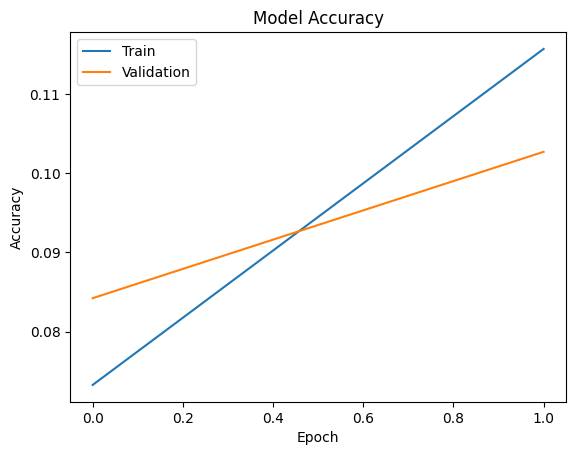

In [ ]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Corpus length: 10994
Sample words: ['pizza', 'the', 'delectable', 'and', 'iconic', 'dish', 'that', 'has', 'transcended', 'borders', 'and', 'captivated', 'taste', 'buds', 'worldwide', 'is', 'a', 'testament', 'to', 'the']
Unique words: 683
Example sequence: ['pizza', 'the', 'delectable', 'and', 'iconic'] -> dish
Shape of X: (1709, 5, 683)
Shape of Y: (1709, 683)
Epoch 1/2
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.0407 - loss: 6.1963 - val_accuracy: 0.0581 - val_loss: 6.1972
Epoch 2/2
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0536 - loss: 5.7555 - val_accuracy: 0.0465 - val_loss: 6.4312


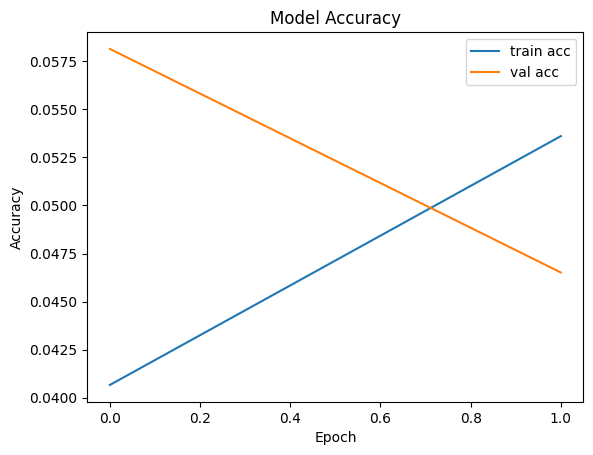

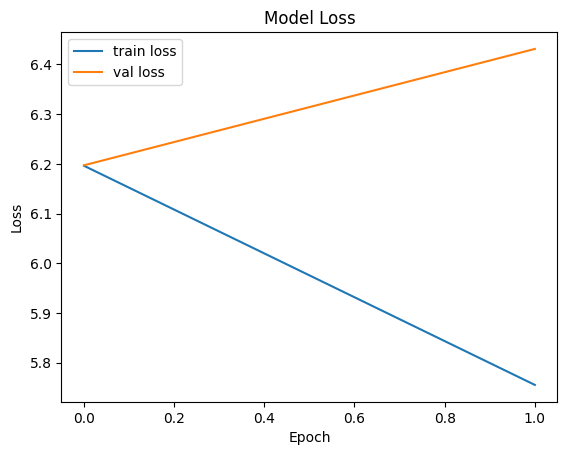

In [4]:
# ---------- IMPORTS ----------
import numpy as np
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Activation
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

# ---------- LOAD DATA ----------
path = r"D:\NLP\pizza.txt"
text = open(path, encoding='utf-8').read().lower()
print("Corpus length:", len(text))

# ---------- TOKENIZATION ----------
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)
print("Sample words:", words[:20])

unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))
print("Unique words:", len(unique_words))

# ---------- SEQUENCE CREATION ----------
WORD_LENGTH = 5
prev_words = []
next_words = []

for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])

print("Example sequence:", prev_words[0], "->", next_words[0])

# ---------- PREPARE X, Y ----------
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)

for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

# ---------- BUILD MODEL ----------
model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation("softmax"))

optimizer = RMSprop(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# ---------- TRAIN MODEL ----------
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=2, shuffle=True).history

# ---------- SAVE MODEL ----------
model.save("keras_next_word_model.h5")
pickle.dump(history, open("history.p", "wb"))

# ---------- EVALUATION PLOTS ----------
plt.plot(history["accuracy"], label="train acc")
plt.plot(history["val_accuracy"], label="val acc")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history["loss"], label="train loss")
plt.plot(history["val_loss"], label="val loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()